# ELT pipeline

I have create a ETL pipeline for extracting a dataset from Kaggle, transformed with PySpark and load the dataset into a Postgres database. The final output will be use for do exploratory data analysis using matplotlib and create a dashborad with Power BI.

## Loading packages

In [1]:
!pip install kaggle

In [1]:
#import kaggle
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, IntegerType, DateType
from pyspark.sql.functions import when, col, lit, to_date, month
from pyspark.ml.feature import Bucketizer
import psycopg2
import scipy.stats as ss
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Creating ETL steps

In [3]:
def extract_kaggle_dataset(url_kaggle):
    """ Connect with given kaggle url to download all available files.
    Arg:
        url_kaggle (string): kaggle url from any repository you want to download files.
    """
    # This extract all files from a given kaggle url
    kaggle.api.dataset_download_files(url_kaggle, quiet=False, unzip=True)

In [4]:
def transform(csv_1, csv_2):
    
    """
    Load dataset as spark dataframes, merge and transform both loaded datasets and save merged and transformed dataframe
    into a single csv file. For more information, follow the comments on each line of code.
    Arg:
        csv_1 (string): csv file corresponding to the 1st data set.
        csv_2 (string): csv file corresponding to the 2nd data set.
    """
    
    spark = SparkSession.builder.appName('UK_traffic').getOrCreate()

    # Loading accident csv file into spark dataframe
    
    accident = spark.read.load(csv_1, 
                               format="csv", 
                               sep=",", 
                               inferSchema="true", 
                               header="true")
    
    # Here, a SELECT operation is performed to keep just desired columns
    accident = accident.select('Accident_Index',
                               'Accident_Severity',
                               'Date', 
                               'Day_of_Week',
                               'Number_of_Casualties',
                               'Number_of_Vehicles', 
                               'Road_Surface_Conditions',
                               'Road_Type', 
                               'Speed_limit',
                               'Weather_Conditions',
                               'Year')

    # Loading accident csv file into spark dataframe.
    
    vehicle = spark.read.load(csv_2,
                              format="csv", 
                              sep=",",
                              inferSchema="true",
                              header="true")
    
    # Here, a SELECT operation is performed to keep just desired columns
    vehicle = vehicle.select('Accident_Index',
                             'Age_Band_of_Driver', 
                             'Age_of_Vehicle',
                             'Driver_Home_Area_Type',
                             'Journey_Purpose_of_Driver',
                             'Sex_of_Driver',
                             'Vehicle_Type',
                             'Year')
                                                    
    # The accident_index column name will be changed to avoid key duplication after JOIN operation  
  
    accident = accident.withColumnRenamed('Accident_Index', 'Accident_Index_Acc')
    vehicle = vehicle.withColumnRenamed('Accident_Index', 'Accident_Index_Veh')

    # Here, the 2 dataset are filtered by years 2016,2015,2014 in a multiple condition FILTER operations; 
    # The idea is to keep the records from 2014 to 2016, the most recent years 

    accident = accident.filter( (accident["Year"] == 2016) | (accident["Year"] == 2015) | (accident["Year"] == 2014) )
    vehicle = vehicle.filter( (vehicle["Year"] == 2016) | (vehicle["Year"] == 2015) | (vehicle["Year"] == 2014) )
    vehicle = vehicle.drop('Year')

    # Here, vehicle dataset is filtered to keep only the records when cars was involved
    vehicle = vehicle.filter(vehicle["Vehicle_Type"] == 'Car')
                    
    # Inner JOIN to merge 2 datasets                            
    full = vehicle.join(accident,
                        vehicle.Accident_Index_Veh ==  accident.Accident_Index_Acc,
                        "inner").drop('Accident_Index_Acc')

    # Changing missing values placeholder to None. This way Spark can identify properly null values.
    full = full.replace('Data missing or out of range', None).replace('NA', None)

    # Filtering inconsistent age band from 0 to 15 years old; unrealistic legal driving age.
    full = full.filter(full['Age_Band_of_Driver'] != '0 - 5').filter(full['Age_Band_of_Driver'] != '6 - 10').filter(full['Age_Band_of_Driver'] != '11 - 15')

    # Creating a columns to store a weekday or weekend boolean variable.
    full = full.withColumn("Weekday_or_Weekend",when((full['Day_of_Week'] == 'Saturday') | (full['Day_of_Week'] == 'Sunday'), lit("Weekend")).otherwise(lit("Weekday")))

    # Changing date column to a proper date format and extracting month of the year.
    full = full.withColumn("Date_format",to_date(col('Date'), 'yyyy-MM-dd')).withColumn("Month_of_Year",month(col('Date_format')))

    # Changing column format
    full = full.withColumn('Date', col('Date').cast(DateType()))
    full = full.withColumn('Year', col('Year').cast(StringType()))
    full = full .withColumn('Age_of_Vehicle', col('Age_of_Vehicle').cast(IntegerType()))
    
    # Discretizing age of vehicle variable. from continuos to  categorical
    splits = [0,5,10,20, float("inf")]
    bucketizer = Bucketizer(splits=splits, inputCol="Age_of_Vehicle", outputCol="Age_of_Vehicle_Bucketized")
    full = bucketizer.transform(full)
    full = full.withColumn('Age_of_Vehicle_Bucketized', col('Age_of_Vehicle_Bucketized').cast(StringType()))
    full = full.na.replace({'0.0': '0 - 5','1.0':'5 - 10','2.0':'10 - 20', '3.0':'> 20'},'Age_of_Vehicle_Bucketized')
    full = full.drop('Age_of_Vehicle')
    full = full.withColumnRenamed('Age_of_Vehicle_Bucketized', 'Age_of_Vehicle')
    
    # Dropping date columns and vehicle type
    full = full.drop('Date').drop('Vehicle_Type')

    # Saving dataframe into a single csv file.
    full.repartition(1).write.option("header",True).option("sep",";").csv('uk_traffic')

In [2]:
def load_to_postgres(csv_path, 
                     host_local, 
                     user_local, 
                     password_local,
                     port_number):
    """ 
    Take transformed csv file output and load it into a PostGres database
    
    Args:
        csv_path (string): path where the transformed csv was outputed
        host_local (string): Postgres local host name
        user_local (string): Postgre local user
        password_local (string): Postgre password server
        port_number (string): Local default port number
    
    """
    # Connecting to postgres local host
    conn = psycopg2.connect(host=host_local,
                            user=user_local,
                            password =password_local,
                            port=port_number)

    conn.autocommit = True

    cursor = conn.cursor()
    
    # SQL query for create database
    sql = '''CREATE DATABASE uk_traffic;'''

    # The previous SQL query is executed 
    cursor.execute(sql)

    conn.close()
    
    # Connecting to postgres local new database
    conn = psycopg2.connect(database='uk_traffic',
                            host=host_local,
                            user=user_local,
                            password =password_local,
                            port=port_number)

    conn.autocommit = True

    cursor  = conn.cursor()
    
    # SQL query for create table with the same column as transform output csv
    sql ='''CREATE TABLE uk_road_safety(
                Accident_index_veh VARCHAR(50) NOT NULL,
                Age_band_of_driver VARCHAR(50),
                Driver_Home_Area_Type VARCHAR(50),
                Journey_Purpose_of_Driver VARCHAR(50),
                Sex_of_Driver VARCHAR(15),
                Accident_Severity VARCHAR(50),
                Day_of_Week VARCHAR(15),
                Number_of_Casualties int,
                Number_of_Vehicles int,
                Road_Surface_Conditions VARCHAR(50),
                Road_Type VARCHAR(50),
                Speed_limit VARCHAR(10),
                Weather_Conditions VARCHAR(50),
                Year int,
                Weekday_or_Weekend VARCHAR(50),
                Date_format TIMESTAMP,
                Month_of_Year int,
                Age_of_vehicle VARCHAR(50)
            ); '''
    
    cursor.execute(sql)
    
    # Here, we take the csv file outputed from transform step to populate uk_road_safety table
    
    with open(csv_path, 'r') as f:
        # Notice that we don't need the `csv` module.
        next(f) # Skip the header row.
        cursor.copy_from(f, 'uk_road_safety', sep=';')
    # At this point, database and tables has been created
    conn.close()

### This additional method is for calculate correlation between categorical features.

In [40]:
def cramers_corrected_stat(x,y):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
        Args:
            - x (pandas' Series): categorical dependent variable.
            - y (pandas' Series): categorical target variable.
    """
    result=-1
    if len(x.value_counts())==1 :
        print("First variable is constant")
    elif len(y.value_counts())==1:
        print("Second variable is constant")
    else:   
        conf_matrix=pd.crosstab(x, y)

        if conf_matrix.shape[0]==2:
            correct=False
        else:
            correct=True

        chi2 = ss.chi2_contingency(conf_matrix, correction=correct)[0]

        n = sum(conf_matrix.sum())
        phi2 = chi2/n
        r,k = conf_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        result=np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
    return round(result,6)

## ETL starts

Please, change the following variables. credentials variable will stored Postgres information connection to server.

In [2]:
# Extract step argument
url_to_download = 'tsiaras/uk-road-safety-accidents-and-vehicles'

# Transform step arguments
csv_file_1 = 'Accident_Information.csv'
csv_file_2 = 'Vehicle_Information.csv'

# Load step arguments

credentials = {'host_local': 'localhost',
               'user_local': 'postgres',
               'password_local': 'milesdavis',
               'port_number':  '5432'
              }

The following code is aimed to find the resulting csv from transform step. It is no possible to change csv name when writing it in Spark. Then, we need to search it in our working directory with default name. We cannot know the csv name beforehand so, we use glob module to search the csv file in folder. Finally, we store this path into new_csv_path variable to use it in the load step 

In [ ]:
# Using os module, we paste current working directory path, folder's name and '*.csv' string.
# Then, we use glob to search any csv.

path = os.getcwd() + '\\uk_traffic\\*.csv'
new_csv_path = glob.glob(path)[0]

### 1) Extract

In [8]:
extract_kaggle_dataset(url_kaggle=url_to_download )

100%|███████████████████████████████████████████████████████████████████████████████| 142M/142M [01:12<00:00, 2.05MB/s]


### 2) Transform

In [9]:
transform(csv_1=csv_file_1 , csv_2=csv_file_2)

C:\Users\Trevo\anaconda3\lib\site-packages\pyspark\sql\dataframe.py:2213: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


### 3) Load

The following code is aimed to find the resulting csv from transform step. It is no possible to change csv name when writing it in Spark. Then, we need to search it in our working directory with default name. We cannot know the csv name beforehand so, we use glob module to search the csv file in folder. Finally, we store this path into new_csv_path variable to use it in the load step 

In [5]:
load_to_postgres(csv_path = new_csv_path,
                 host_local=credentials['host_local'],
                 user_local=credentials['user_local'],
                 password_local=credentials['password_local'],
                 port_number=credentials['port_number'])

## Exploratory data analysis

We'll do some interesting plots to know more about this dataset

In [4]:
uk_road = pd.read_csv(new_csv_path, sep=';')

How does it look, table-wise

In [12]:
uk_road.head()

,Accident_Index_Veh,Age_Band_of_Driver,Driver_Home_Area_Type,Journey_Purpose_of_Driver,Sex_of_Driver,Accident_Severity,Day_of_Week,Number_of_Casualties,Number_of_Vehicles,Road_Surface_Conditions,Road_Type,Speed_limit,Weather_Conditions,Year,Weekday_or_Weekend,Date_format,Month_of_Year,Age_of_Vehicle
0,201401BS70013,36 - 45,Urban area,Not known,Male,Slight,Sunday,1,2,Wet or damp,Single carriageway,30.0,Raining no high winds,2014,Weekend,2014-01-05,1,0 - 5
1,201401BS70016,36 - 45,Urban area,Journey as part of work,Male,Serious,Thursday,1,1,Wet or damp,Single carriageway,30.0,Raining no high winds,2014,Weekday,2014-01-23,1,0 - 5
2,201401BS70027,26 - 35,Urban area,Not known,Male,Slight,Monday,1,2,Wet or damp,Single carriageway,30.0,Raining no high winds,2014,Weekday,2014-01-27,1,10 - 20
3,201401BS70059,46 - 55,Urban area,Not known,Female,Slight,Thursday,1,2,Wet or damp,Single carriageway,30.0,Fine no high winds,2014,Weekday,2014-02-06,2,0 - 5
4,201401BS70065,46 - 55,NaN,Not known,Male,Slight,Saturday,1,2,Wet or damp,Single carriageway,30.0,Raining no high winds,2014,Weekend,2014-02-08,2,10 - 20


Accident severity

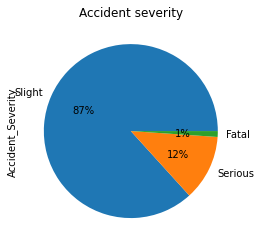

In [60]:
uk_road['Accident_Severity'].value_counts().plot.pie(title='Accident severity',autopct='%.0f%%')
plt.show()

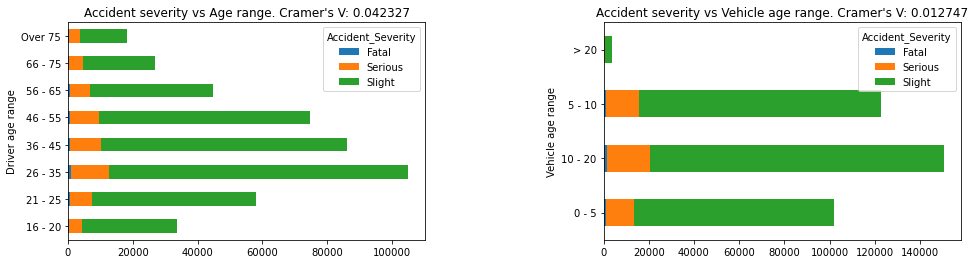

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

plt.subplots_adjust(wspace=0.5, hspace=0.5)

cramers_v_corr = cramers_corrected_stat(uk_road['Age_Band_of_Driver'],uk_road['Accident_Severity'])
pd.crosstab(uk_road['Age_Band_of_Driver'],uk_road['Accident_Severity']).plot.barh(stacked=True,
                                                                                  ax=axes[0],
                                                                                  xlabel='Driver age range',
                                                                                  ylabel='Counts',
                                                                                  title="Accident severity vs Age range. Cramer's V: {}".format(cramers_v_corr))

cramers_v_corr = cramers_corrected_stat(uk_road['Age_of_Vehicle'],uk_road['Accident_Severity'])
pd.crosstab(uk_road['Age_of_Vehicle'],uk_road['Accident_Severity']).plot.barh(stacked=True,
                                                                              ax=axes[1],
                                                                              xlabel='Vehicle age range',
                                                                              ylabel='Counts',
                                                                              title="Accident severity vs Vehicle age range. Cramer's V: {}".format(cramers_v_corr))




plt.show()


Most of the accidents involved people from 26 - 35 years old which is average working age and it is follow by the 36-45 years old range where most driver are more experienced thus experience reduce accident frequency but no severity. There's no strong association between Accident severity and driver's age range or vehicle age range.

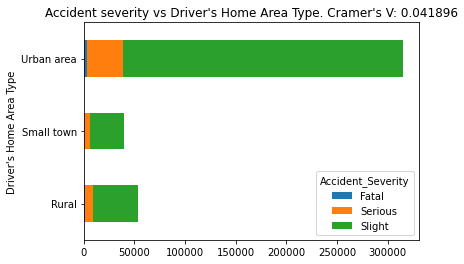

In [44]:
cramers_v_corr = cramers_corrected_stat(uk_road['Driver_Home_Area_Type'],uk_road['Accident_Severity'])
pd.crosstab(uk_road['Driver_Home_Area_Type'],uk_road['Accident_Severity']).plot.barh(stacked=True, 
                                                                                     xlabel="Driver's Home Area Type",
                                                                                     ylabel='Counts',
                                                                                     title="Accident severity vs Driver's Home Area Type. Cramer's V: {}".format(cramers_v_corr))
plt.show()

This plot says the expected; most of the accident occurs in the urban areas where most traffic is encounter but there's no strong association between Accident severity and driver's Home area type.

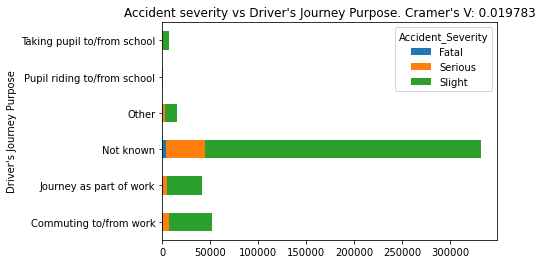

In [45]:
cramers_v_corr = cramers_corrected_stat(uk_road['Journey_Purpose_of_Driver'],uk_road['Accident_Severity'])
pd.crosstab(uk_road['Journey_Purpose_of_Driver'],uk_road['Accident_Severity']).plot.barh(stacked=True, 
                                                                                         xlabel="Driver's Journey Purpose",
                                                                                         ylabel='Counts',
                                                                                         title="Accident severity vs Driver's Journey Purpose. Cramer's V: {}".format(cramers_v_corr)
                                                                                        )
plt.show()

Most of the entries in Journey purpose of driver are "not know" then it is no too usefull to assess some kind of interesting correlation between those 2 variables. There's no strong association between accident severity and driver's journey purpose.

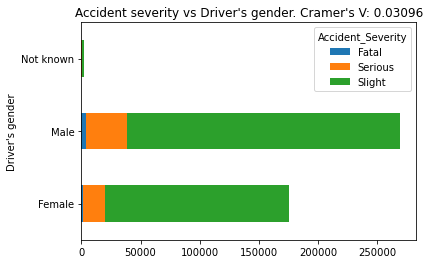

In [46]:
cramers_v_corr = cramers_corrected_stat(uk_road['Sex_of_Driver'],uk_road['Accident_Severity'])
pd.crosstab(uk_road['Sex_of_Driver'],uk_road['Accident_Severity']).plot.barh(stacked=True, 
                                                                             xlabel="Driver's gender",
                                                                             ylabel='Counts',
                                                                             title="Accident severity vs Driver's gender. Cramer's V: {}".format(cramers_v_corr)
                                                                            )
plt.show()

It seems that men are more prone to vehicle accidents that women but we must be aware of the gender bais in data. We'll need more gender-equality oriented information to have better gender-oriented insights. Hopely, There's no strong association between accident severity and driver's gender.

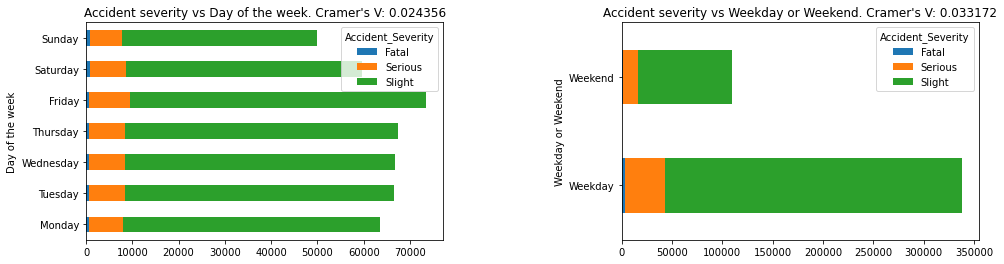

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

plt.subplots_adjust(wspace=0.5, hspace=0.5)

days_of_week = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

cramers_v_corr = cramers_corrected_stat(uk_road['Day_of_Week'],uk_road['Accident_Severity'])
pd.crosstab(uk_road['Day_of_Week'],uk_road['Accident_Severity']).loc[days_of_week].plot.barh(stacked=True,
                                                                                             ax=axes[0], 
                                                                                             xlabel="Day of the week",
                                                                                             ylabel='Counts',
                                                                                             title="Accident severity vs Day of the week. Cramer's V: {}".format(cramers_v_corr)
                                                                                            )

cramers_v_corr = cramers_corrected_stat(uk_road['Weekday_or_Weekend'],uk_road['Accident_Severity'])
pd.crosstab(uk_road['Weekday_or_Weekend'],uk_road['Accident_Severity']).plot.barh(stacked=True,
                                                                                  ax=axes[1],
                                                                                  xlabel="Weekday or Weekend",
                                                                                  ylabel='Counts',
                                                                                  title="Accident severity vs Weekday or Weekend. Cramer's V: {}".format(cramers_v_corr)   
                                                                                 )

plt.show()

It seems that there is no correlation between the acciddent severity or frequency with the day of the week but it is sligthy more frequent on friday; one recommendation can be less deliveries on fridays. Further, as expected, accident are more likely to happen in weekdays where our couriers will be working. so, we need to be more carefull at the moment of delivery scheduling. 

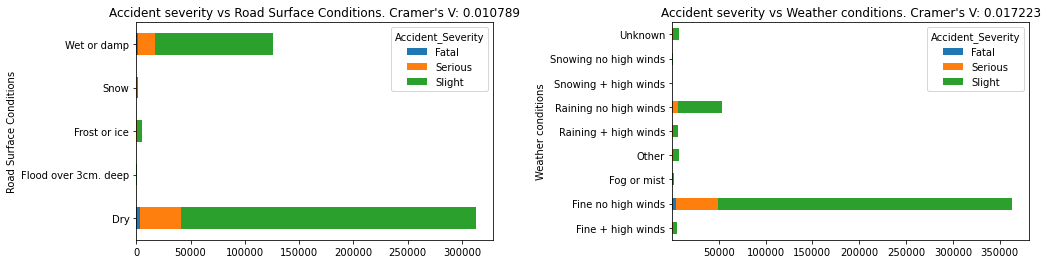

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

plt.subplots_adjust(wspace=0.5, hspace=0.5)

cramers_v_corr = cramers_corrected_stat(uk_road['Road_Surface_Conditions'],uk_road['Accident_Severity'])
pd.crosstab(uk_road['Road_Surface_Conditions'],uk_road['Accident_Severity']).plot.barh(stacked=True,
                                                                                       ax=axes[0],
                                                                                       xlabel="Road Surface Conditions",
                                                                                       ylabel='Counts',
                                                                                       title="Accident severity vs Road Surface Conditions. Cramer's V: {}".format(cramers_v_corr)
                                                                                      )

cramers_v_corr = cramers_corrected_stat(uk_road['Weather_Conditions'],uk_road['Accident_Severity'])
pd.crosstab(uk_road['Weather_Conditions'],uk_road['Accident_Severity']).plot.barh(stacked=True,
                                                                                  ax=axes[1],
                                                                                  xlabel="Weather conditions",
                                                                                  ylabel='Counts',
                                                                                  title="Accident severity vs Weather conditions. Cramer's V: {}".format(cramers_v_corr)
                                                                                 )
plt.show()

Vehicle accidents are more likey to happen in non-extreme conditions namely dry road and sunny weather.

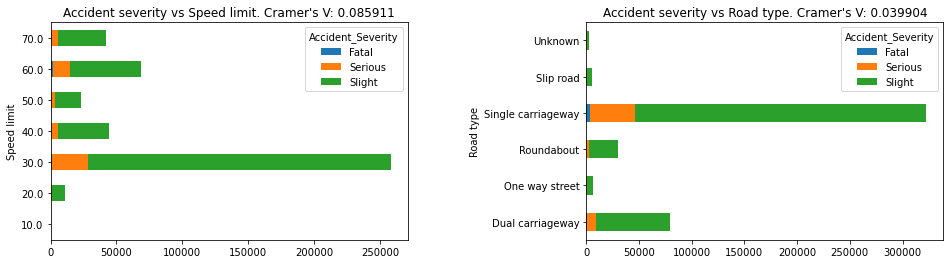

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

plt.subplots_adjust(wspace=0.5, hspace=0.5)

cramers_v_corr = cramers_corrected_stat(uk_road['Speed_limit'],uk_road['Accident_Severity'])
pd.crosstab(uk_road['Speed_limit'],uk_road['Accident_Severity']).plot.barh(stacked=True,
                                                                           ax=axes[0],
                                                                           xlabel="Speed limit",
                                                                           ylabel='Counts',
                                                                           title="Accident severity vs Speed limit. Cramer's V: {}".format(cramers_v_corr)
                                                                          )

cramers_v_corr = cramers_corrected_stat(uk_road['Road_Type'],uk_road['Accident_Severity'])
pd.crosstab(uk_road['Road_Type'],uk_road['Accident_Severity']).plot.barh(stacked=True,
                                                                         ax=axes[1],
                                                                         xlabel="Road type",
                                                                         ylabel='Counts',
                                                                         title="Accident severity vs Road type. Cramer's V: {}".format(cramers_v_corr)
                                                                        )


plt.show()

Contrary to the popular belief that most accident happen in highways or high speed limit. This suggest that accident happen in cities or urban scenarios. Then, safe driving practices have to be reenforce to our couriers to prevent any accident or traffic adverse situation.

In [50]:
uk_road['Month_of_Year'].replace(to_replace={1:'January',
                                             2:'February',
                                             3:'March',
                                             4:'April',
                                             5:'May',
                                             6:'June',
                                             7:'July',
                                             8:'August',
                                             9:'September',
                                             10:'October',
                                             11:'November',
                                             12:'December'},
                                 inplace=True)

months_of_year = ['January','February','March','April','May','June','July','August','September','October','November','December']

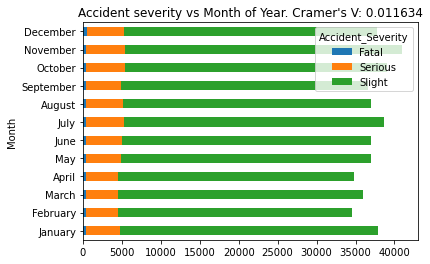

In [51]:
cramers_v_corr = cramers_corrected_stat(uk_road['Month_of_Year'],uk_road['Accident_Severity'])
pd.crosstab(uk_road['Month_of_Year'],uk_road['Accident_Severity']).loc[months_of_year].plot.barh(stacked=True,
                                                                                                 xlabel="Month",
                                                                                                 ylabel='Counts',
                                                                                                 title="Accident severity vs Month of Year. Cramer's V: {}".format(cramers_v_corr)
                                                                                                )

plt.show()

 There no correlation between accidents and seasion or month of the year. One's may say that due to the summer traffic and vacations, accident are more likely but it is no the case, likely.